## Introduction
Object detection is a fundamental task in computer vision. The problem of object recognition essentially consists of first localizing the object and then classifying it with a semantic label. In recent deep learning based methods, YOLO is an extremely fast real time multi object detection algorithm.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_1.png"/></div>
<center>Figure 1: This is a demo of what object detection does. The color indicates different semantic class.</center>  
  
In this project, we provide 10K street scene images with correponding labels as training data. The image dimension is $128 \times 128 \times 3$, and the labels include the semantic class and the bounding box corresponding to each object in the image. Note that a small portion of these ground-truth labels are not a little bit noisy and the quantity of the training set is not very large, so we do not expect you to learn a super robust object detector.

## Data Preprocessing
For this section, you will need to write code to preprocess the ground truth labels for the YOLO algorithm. The
labels are provided in the "label" folder. The format of the labels are (class, $x_1$, $y_1$, $x_2$, $y_2$), where $x_1$, $y_1$ are the top left corner of the bounding box and $x_2$, $y_2$ are the bottom right corner of the bounding box.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_2.png"/></div>
<center>Figure 2: This figure demonstrates the format of ground-truth labels that YOLO algorithm requires.</center>  
  
For each image, you are required to convert the provided labels into the $8 \times 8 \times 8$ ground truth matrix, which has the same dimension as the output of YOLO detection network. The instructions of this conversion is as follows:
* We consider a $16 \times 16$ image patch as a grid cell and thus divide the full image into $8 \times 8$ patches in the 2D spatial dimension. In the output activation space, one grid cell represents one 16x16 image patch with corresponding aligned locations.
* For simplified YOLO, we only use one anchor box, where we assume the anchor size is the same as the grid cell size. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. This means that there is only one anchor for each object instance.
* For each anchor, there are 8 channels, which encode Pr(Objectness), $x$, $y$, $w$, $h$, P(class=pedestrian),  P(class=traffic light), and P(class=car).
* The Pr(Objectness) is the probability of whether this anchor is an object or background. When assigning the ground-truth for this value, "1" indicates object and "0" indicates background.
* The channels 2-5, $x$, $y$ coordinates represent the center of the box relative to the bounds of the grid cell; $w$, $h$ is relative to the image width and height.
* In channels 6-8, you need to convert the ground truth semantic label of each object into one-hot coding for each anchor boxes.
* Note that if the anchor box does not have any object (Pr=0), you dont need to assign any values to channels 2-8, since we will not use them during training.
* The dimensions are ordered (channels, x, y).

## Model Architecture
You are required to implement the model architecture using the following parameters. This model takes input with dimension of $128 \times 128 \times 3$ and outputs an activation with dimension of $8 \times 8 \times 8$.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_3.png"/></div>
<center>Figure 3: This figure demonstrates how to compute IoU.</center>

| Layer | Hyperparameters |
| :-: | :-: |
| conv1 | Kernel size $= 4 \times 4 \times 32$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv2 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv3 | Kernel size $= 4 \times 4 \times 128$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv4 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv5 | Kernel size $= 4 \times 4 \times 512$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv6 | Kernel size $= 4 \times 4 \times 1024$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv7 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv8 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv9 | Kernel size $= 3 \times 3 \times 8$, stride $=1$, pad $=1$. |


## Training Details
During training, the localization and classification errors are optimized jointly. The loss function is shown
as below.  $i$ indicates number of grid cells and $j$ indicates number of anchor boxes at each grid cell. In our
case, there is only one anchor box at each grid cell and $B = 1$.

$$ \text{Loss} = 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(x_i - \hat{x}_i\right)}^2 + {\left(y_i - \hat{y}_i\right)}^2\right]} + 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)}^2 + {\left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)}^2\right]} + 
{\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left(C_i - \hat{C}_i\right)^2} + 
{\lambda_\text{no obj} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{no obj} \left(C_i - \hat{C}_i\right)^2} + 
{\sum_{i=0}^{S^2} \mathbb{1}_{ij}^\text{obj} \sum_{c\, \in\, \text{classes}} \left(p_i(c) - \hat{p}_i(c)\right)^2}$$

* In our case there is only one anchor box at each grid, hence $B = 1$.
* $S^2 =$ total number of grid cells.
* $\mathbb{1}_{ij}^\text{obj} = 1$ if an object appears in grid cell $i$ and 0 otherwise.
* $\mathbb{1}_{ij}^\text{no obj}$ is the compliment of $\mathbb{1}_{ij}^\text{obj}$.
* $\hat{C}_i =$ Box confidence score $=$ Pr(box contains object) $\times$ IoU
* IoU $=$ Intersection over union between the predicted and the ground truth.
* $\hat{p}_i(c) =$ conditional class probability of class $c$ in cell $i$.

$\lambda_\text{coord}$ and and $\lambda_\text{no obj}$ are two hyperparameters for coordinate predictions and non-objectness classification. We set $\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$.

Each grid cell predicts 1 bounding box, confidence score for those boxes and class conditional probabilities.

The confidence Score reflects the degree of confidence that the box contains an object and how accurate the box is. If no object exists in the cell then the confidence score should be 0 else the confidence score should be equal to the IOU between the predicted box and the ground truth box.

During training, you can set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2. You are encourage to adaptively adjust learning rate during training to see if the model will converge better. You should also visualize the loss over training iterations. You will need to decide at the iteration to stop training based on the loss visualization. (At least 20 epochs of training is required.)

## Post-Processing
During inference, the network is going to predict lots of overlapping redundant bounding boxes. To eliminate the redundant boxes, there are basically two steps:

1. Get rid of predicted boxes with low objectness probability (Pr $< 0.6$).
2. For each class, calculate the IoU for all the bounding boxes and cluster boxes with IoU > 0.5 as a group. For each group, find the one with highest Pr and suppress the other boxes. This is referred as non-max suppression.

To evaluate the performance of your YOLO implementation, compute the mean Average Precision (mAP) of inference. Predicted bounding boxes are a match with ground truth bounding boxes if they share the same label and have an IoU with the ground truth bounding box of greater than 0.5. These matches can be used to calculate a precision/recall curve for each class. The Average Precision for a class is the area under this curve. The mean of these Average Precision values over all the classes in inference gives the mean Average Precision of your network.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_4.png"/></div>
<center>Figure 4: This figure demonstrates post-process of how to get rid of redundant bounding box.</center>

## Initialization

In [ ]:

if 'google.colab' in str(get_ipython()):
    # Colab specific setup
    assignment_path = '/content/gdrive/My Drive/CIS680_2021/HW2/'
    
    # Mount your drive
    from google.colab import drive
    drive.mount("/content/gdrive")
    
    # Setup assignment folder and switch
    import os
    os.makedirs(assignment_path, exist_ok=True)
    os.chdir(assignment_path)
    
    # Only download files once
    if not os.path.isdir('tests'):
        !gdown --id 1QxzpuZoca68S-ZCfdqyWph7a-tfwa1az
        !unzip -u hw2_additional_files.zip && rm hw2_additional_files.zip
        
    !pip install otter-grader pytorch_lightning &> /dev/null
    
notebook_name = 'cis680_hw2.ipynb'
import otter
grader = otter.Notebook(notebook_name)
grader._colab = False

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Code

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

In [ ]:
# Use this function to import the provided data files
def load_data(file_name):
    return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

images = load_data('images.npz')
raw_labels = load_data('labels.npz')

In [ ]:
# This function displays the images with the color coded bounding boxes
def display(image, raw_label):
    cmap = {2:'green',1:'blue',0:'red'}
    print('number of bounding boxes', len(raw_label))
    figure, ax = plt.subplots(1)
    for c,x1,y1,x2,y2 in raw_label:
        w = abs(x1-x2)
        h = abs(y1-y2)
        x = x2-w
        y = y2-h
        rect = Rectangle((x,y),w,h, edgecolor=cmap[c], facecolor="none")
        ax.add_patch(rect)
    ax.imshow(image)

In [ ]:
# This function should compute the 8X8X8 label from the raw labels for the corresponding image.
def process_labels(raw_labels):
  labels = []

  for raw_label in raw_labels:
    Y_label = torch.zeros(8,8,8)
    grid_size_x = 16
    grid_size_y = 16

    for bb in raw_label:
      c = bb[0]
      x1 = bb[1]
      y1 = bb[2]
      x2 = bb[3]
      y2 = bb[4]

      # FIRST CHANNEL
      center_x = (x1 + x2)/2
      center_y = (y1 + y2)/2
      
      grid_x = center_x/grid_size_x
      grid_y = center_y/grid_size_y
      grid_x = int(grid_x)
      grid_y = int(grid_y)
      Y_label[0,grid_x,grid_y] = 1

      # SECOND & THIRD CHANNEL
      x = (center_x%grid_size_x)/grid_size_x
      y = (center_y%grid_size_y)/grid_size_y
      Y_label[1,grid_x,grid_y] = round(x,2)
      Y_label[2,grid_x,grid_y] = round(y,2)

      # THIRD & FOURTH CHANNEL
      w = (x2-x1)/128
      h = (y2-y1)/128
      Y_label[3,grid_x,grid_y] = round(w,2)
      Y_label[4,grid_x,grid_y] = round(h,2)

      # FIFTH SIXTH & SEVENTH CHANNEL
      Y_label[5,grid_x,grid_y] = sum([c==0])
      Y_label[6,grid_x,grid_y] = sum([c==1])
      Y_label[7,grid_x,grid_y] = sum([c==2])

    labels.append(Y_label.numpy())

  return labels

In [ ]:
# This function should perform the inverse operation of process_labels().
def reconstruct_raw_labels(labels, img_dim=128):
  soln = []
  for label in labels:
    raw_label = []
    for i in range(8):
      for j in range(8):
        if label[0,i,j]==1:
          grid_x = i
          grid_y = j
          grid_size_x = 16
          grid_size_y = 16
          x = label[1,i,j]
          y = label[2,i,j]
          w = label[3,i,j]
          h = label[4,i,j]

          # LINEAR EQUATION SOLVING for X1, X2
          x2 = round(16*(grid_x+x) + 64*w,0)
          x1 = round(32*(grid_x+x) - x2,0)

          # LINEAR EQUATION SOLVING for Y1, Y2
          y2 = round(16*(grid_y+y) + 64*h,0)
          y1 = round(32*(grid_y+y) - y2,0)

          if label[5,i,j]==1:
            c = 0
          elif label[6,i,j]==1:
            c = 1
          else:
            c = 2

          raw_label.append([c,x1,y1,x2,y2])
    soln.append(np.array(raw_label))
  return np.array(soln)

In [ ]:
  # from sklearn import metrics
  def IOU(prediction, grnd_truth, object_idx):
    #Extracting centers and h w
    cpx = prediction[:,0]
    cpy = prediction[:,1]
    wp = prediction[:,2]
    hp = prediction[:,3]
    
    
    cgx = grnd_truth[:,0]
    cgy = grnd_truth[:,1]
    wg = grnd_truth[:,2]
    hg = grnd_truth[:,3]

   
    
    
    wp= wp * 128
    hp= hp * 128
    wg= wg * 128
    hg= hg * 128

   
    cpx = cpx * 16 + object_idx[:,0] * 16
    cpy = cpy * 16 + object_idx[:,1] * 16
    cgx = cgx * 16 + object_idx[:,0] * 16
    cgy = cgy * 16 + object_idx[:,1] * 16

    
    box1 =  [cpx-wp/2, cpy-hp/2, cpx+wp/2, cpy+hp/2]
    box2 =  [cgx-wg/2, cgy-hg/2, cgx+wg/2, cgy+hg/2]

    xA = torch.max(box1[0], box2[0])
    yA = torch.max(box1[1], box2[1])

    xB = torch.min(box1[2], box2[2])
    yB = torch.min(box1[3], box2[3])

    area_intersection = torch.max(xB-xA, torch.zeros(xB.shape, dtype=xB.dtype)) * torch.max(yB-yA, torch.zeros(yB.shape, dtype=yB.dtype))

    area_union = (box1[2]-box1[0]) * (box1[3]-box1[1]) + (box2[2]-box2[0]) * (box2[3]-box2[1]) - area_intersection

    iou = torch.div(area_intersection,area_union)
    
  
    
    return iou

  def yolo_loss(output, target):
    #n*8*8*8
    lambda_coord= 5
    lambda_noobj =0.5
    object_idx  = target[:,0,:,:].nonzero()
    nobject_idx = (target[:,0,:,:]==0).nonzero()

    target_object    = target[object_idx[:,0],:,object_idx[:,1],object_idx[:,2]]
    predicted_object = output[object_idx[:,0],:,object_idx[:,1],object_idx[:,2]]


    predicted_nobject = output[nobject_idx[:,0],:,nobject_idx[:,1],nobject_idx[:,2]]

    localization_loss = torch.sum((target_object[:,1]-predicted_object[:,1])**2 + 
                                  (target_object[:,2]-predicted_object[:,2])**2)
    
    bbox_loss         = torch.sum((torch.sqrt(target_object[:,3])-torch.sqrt(predicted_object[:,3]))**2 + 
                                  (torch.sqrt(target_object[:,4])-torch.sqrt(predicted_object[:,4]))**2)
    
    iou = IOU(predicted_object[:, 1:5], 
              target_object[:, 1:5], object_idx)
    
    
    
    obj_confidence_loss = torch.sum((iou - predicted_object[:,0])**2)
    
    nobj_confidence_loss= torch.sum((0 - predicted_nobject[:, 0])**2)

    pc_loss = torch.sum((target_object[:,5:]-predicted_object[:,5:])**2)

    loss = lambda_coord*(localization_loss + bbox_loss) + obj_confidence_loss + lambda_noobj*nobj_confidence_loss + pc_loss 
    

    return loss

In [ ]:
# class YOLO(pl.LightningModule):
#     def __init__(self):

        

#     def forward(self, x):
#         ...

#     def training_step(self, batch, batch_idx):
#         ...

#     def validation_step(self, batch, batch_idx):
#         ...

#     def configure_optimizers(self):

class YOLO(torch.nn.Module):
  def __init__(self):
    super(YOLO, self).__init__()
    self.relu = torch.nn.ReLU(inplace=False)
    
    self.conv1 = torch.nn.Conv2d(3,32,kernel_size=4,padding=1, stride=2)
    self.batch_norm1 = torch.nn.BatchNorm2d(32,eps=1e-05,momentum=0.1,
                                            affine=True,track_running_stats=True)
    
    self.conv2 = torch.nn.Conv2d(32,64,kernel_size=4,padding=1, stride=2)
    self.batch_norm2 = torch.nn.BatchNorm2d(64,eps=1e-05,momentum=0.1,
                                            affine=True,track_running_stats=True)

    self.conv3 = torch.nn.Conv2d(64,128,kernel_size=4,padding=1, stride=2)
    self.batch_norm3 = torch.nn.BatchNorm2d(128,eps=1e-05,momentum=0.1,
                                            affine=True,track_running_stats=True)
    
    self.conv4 = torch.nn.Conv2d(128, 256, kernel_size=4,padding=1, stride=2)
    self.batch_norm4 = torch.nn.BatchNorm2d(256,eps=1e-05,momentum=0.1,
                                            affine=True,track_running_stats=True)
    
    self.conv5 = torch.nn.Conv2d(256,512,kernel_size=4,padding=1, stride=2)
    self.batch_norm5 = torch.nn.BatchNorm2d(512,eps=1e-05,momentum=0.1,
                                            affine=True,track_running_stats=True)
    
    self.conv6 = torch.nn.Conv2d(512,1024, kernel_size=4,padding=1, stride=2)
    self.batch_norm6 = torch.nn.BatchNorm2d(1024, eps=1e-05,momentum=0.1,
                                            affine=True,track_running_stats=True)

    self.conv7 = torch.nn.ConvTranspose2d(1024, 256, kernel_size=4,padding=1, stride=2)
    self.batch_norm7 = torch.nn.BatchNorm2d(256, eps=1e-05,momentum=0.1,
                                            affine=True,track_running_stats=True)
    
    self.conv8 = torch.nn.ConvTranspose2d(256, 64, kernel_size=4,padding=1, stride=2)
    self.batch_norm8 = torch.nn.BatchNorm2d(64, eps=1e-05,momentum=0.1,
                                            affine=True,track_running_stats=True)

    self.conv9 = torch.nn.Conv2d(64, 8, kernel_size=3, padding=1, stride=1)


  def forward(self, X):
      layer1 = self.relu(self.batch_norm1(self.conv1(X)))
      layer2 = self.relu(self.batch_norm2(self.conv2(layer1)))
      layer3 = self.relu(self.batch_norm3(self.conv3(layer2)))
      layer4 = self.relu(self.batch_norm4(self.conv4(layer3)))
      layer5 = self.relu(self.batch_norm5(self.conv5(layer4)))
      layer6 = self.relu(self.batch_norm6(self.conv6(layer5)))
      layer7 = self.relu(self.batch_norm7(self.conv7(layer6)))
      layer8 = self.relu(self.batch_norm8(self.conv8(layer7)))
      out = torch.sigmoid(self.conv9(layer8))
      return out


      

In [ ]:
def low_confidence_suppression(label):
    ...
    return label

def non_max_suppression(label):
  nms_threshold = 0.3
  below_threshold = torch.le(nw_output[:,0,:,:],0.6).nonzero()
  nms_output = torch.clone(nw_output)
  nms_output[below_threshold[:,0], 0, below_threshold[:,1], below_threshold[:,2]] = 0
  nms_output1 = torch.clone(nms_output)
  classes = 3
  #print(below_threshold.shape)
  for i in range(nms_output.shape[0]):
    for c in range(classes):
      grid_coords = torch.logical_and(torch.max(nms_output[i,5:8,:,:],dim=0)[1] == c , nms_output[i,0,:,:]>nms_threshold).nonzero() 
      #confidence_scores = nms_output[i,0,grid_coors[:,0],grid_coors[:,1]] * nms_output[i,(5+c),grid_coors[:,0],grid_coors[:,1]]  
      for coord1 in grid_coords:
        confidence_score_c1 = nms_output[i,0,coord1[0],coord1[1]] * nms_output[i,5+c,coord1[0],coord1[1]]
        for coord2 in grid_coords:
          confidence_score_c2 = nms_output[i,0,coord2[0],coord2[1]] * nms_output[i,5+c,coord2[0],coord2[1]]
          if(iou_nms(coord1, coord2, nms_output[i,:,:,:])>0.5 and confidence_score_c1<confidence_score_c2):
            #Supress
            nms_output[i,0,coord1[0],coord1[1]] = 0

  
  return label

In [ ]:
def precision_recall_curve(predictions, targets, target_class):
    ...
    return recall, precision

def average_precision(predictions, targets, target_class):
 
 
  return average_precision

def mean_average_precision(predictions, targets):
    ...
    return mean_average_precision

## Instructions and Evaluation

This project is divided into the following parts:

1. Choose an image that has all three classes present (the image has a car, a person, and a traffic light.
  1. Show the chosen image with ground truth bounding boxes visualized. Use green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights. See Figure 1 as an example of what this visualization should look like. (3%)
  2. Convert the image labels to an 8x8x8 representation, and show each channel of the processed labels in the report. Label the visualization of each channel with the associated channel number and visualized value. Example: "Channel 1: Pr(Objectness)". (5%)
  3. To test your data preprocessing code, convert your 8x8x8 representation for this step back to the original input data and ensure that your image with recomputed bounding boxes looks the same as the input. Show this image with bounding box visualizations in your report. This test code for data preprocessing will also be needed in the inference step. (2%)

number of bounding boxes 8


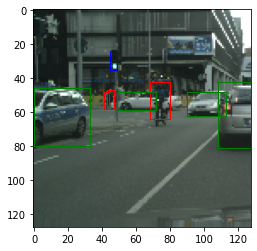

In [ ]:
# Show the chosen image with ground truth bounding boxes visualized.
display(images[8],raw_labels[8])

In [ ]:
# Visualize the 8x8x8 representation.
fwd = process_labels(raw_labels[8:9])

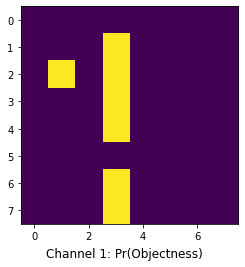

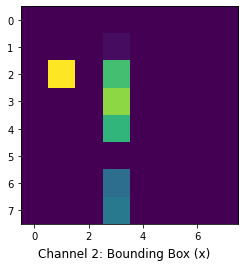

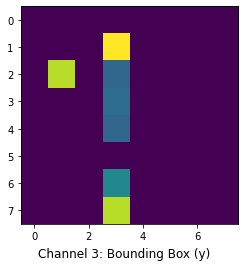

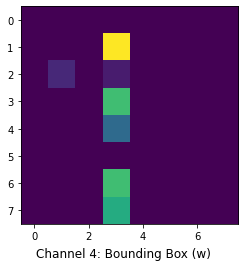

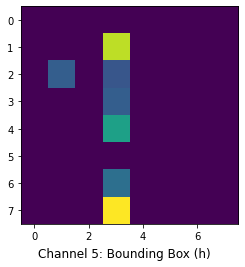

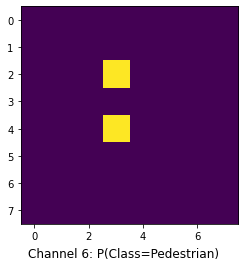

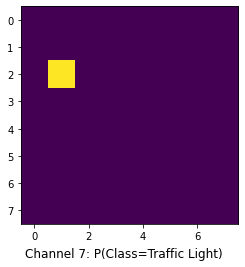

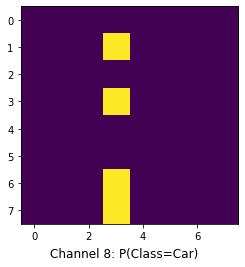

In [ ]:
plt.figure()
plt.figtext(0.5, 0.01, 'Channel 1: Pr(Objectness)', wrap=True, horizontalalignment='center', fontsize=12)
plt.imshow(fwd[0][0])

plt.figure()
plt.figtext(0.5, 0.01, 'Channel 2: Bounding Box (x)', wrap=True, horizontalalignment='center', fontsize=12)
plt.imshow(fwd[0][1])

plt.figure()
plt.figtext(0.5, 0.01, 'Channel 3: Bounding Box (y)', wrap=True, horizontalalignment='center', fontsize=12)
plt.imshow(fwd[0][2])

plt.figure()
plt.figtext(0.5, 0.01, 'Channel 4: Bounding Box (w)', wrap=True, horizontalalignment='center', fontsize=12)
plt.imshow(fwd[0][3])

plt.figure()
plt.figtext(0.5, 0.01, 'Channel 5: Bounding Box (h)', wrap=True, horizontalalignment='center', fontsize=12)
plt.imshow(fwd[0][4])

plt.figure()
plt.figtext(0.5, 0.01, 'Channel 6: P(Class=Pedestrian)', wrap=True, horizontalalignment='center', fontsize=12)
plt.imshow(fwd[0][5])

plt.figure()
plt.figtext(0.5, 0.01, 'Channel 7: P(Class=Traffic Light)', wrap=True, horizontalalignment='center', fontsize=12)
plt.imshow(fwd[0][6])

plt.figure()
plt.figtext(0.5, 0.01, 'Channel 8: P(Class=Car)', wrap=True, horizontalalignment='center', fontsize=12)
plt.imshow(fwd[0][7])

In [ ]:
grader.check("q1b")

q1b results: All test cases passed!

<!-- END QUESTION -->



number of bounding boxes 7


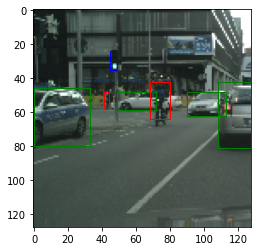

In [ ]:
# Convert back to the original representation (test cases below should pass).
bck = reconstruct_raw_labels(fwd)
display(images[8],bck[0])

In [ ]:
grader.check("q1c")

q1c results: All test cases passed!

2. Implement the loss function. (3%)

In [ ]:
grader.check("q2")

q2 results: All test cases passed!

3. Make block diagram of requested architecture. Label the diagram with the parts of your code which implement each component. Explain any deviations you made from the described architecture. (15%)

**We did not implement the CNN using Pytorch lighting. We used the same approach as the previous homework and we stored each epoch checkpoint as we found this more convenient to implement within the time frame. But, we will employ the pytorch lighting method for the part b of this homework.**

![picture](https://drive.google.com/uc?id=12qSemriEM8nxip4O-o4K7qHkbKNSEx9G)

4. Show a plot of the loss over training for your model. (Raw Tensorboard output is not sufficient) (10%) 

In [ ]:
from sklearn.model_selection import train_test_split
print(images.shape)
imgs =torch.from_numpy(images.reshape(images.shape[0],3,128,128))

labels1 = torch.from_numpy((np.array(process_labels(raw_labels))))

print(images.shape)

print(labels1.shape)
train_imgs,test_imgs,train_labels,test_labels = train_test_split(imgs,labels1,test_size =0.2,random_state =42)

(9900, 128, 128, 3)
(9900, 128, 128, 3)
torch.Size([9900, 8, 8, 8])


In [ ]:

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import  TensorDataset



print(train_imgs.shape,train_labels.shape)


train_dataset = TensorDataset(train_imgs, train_labels)
test_dataset = TensorDataset(test_imgs, test_labels)
train_loader = DataLoader(train_dataset,batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=64, shuffle=True)




torch.Size([7920, 3, 128, 128]) torch.Size([7920, 8, 8, 8])


In [ ]:
net=YOLO()
path = '/content/gdrive/MyDrive/CIS680_2021/HW2/yolo_epoch0'
net=net.to(device)
net.train()
learning_rate = 10e-4

## intialize optimizer
optimizer=torch.optim.Adam(net.parameters(),lr=learning_rate,weight_decay=0.0006)

# if resume == True:
# checkpoint = torch.load(path)
# net.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
  
iterations = 40 
loss_ = []


for epochs in range(iterations):
    ## fill in your training code
    for data in train_loader: 
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      # print(images.shape)
     
      output = net(images.float()).to(device)
      optimizer.zero_grad()
      loss = yolo_loss(output.cpu(), labels.cpu())
      loss.backward()
      optimizer.step()

    if epochs%1==0 :
      loss = yolo_loss(output.cpu(), labels.cpu())
      print("Epoch %d/%d" % (epochs+1, iterations))
      loss_.append(loss.item())
      
      print(loss_)

      
    path = os.path.join('','yolo_epoch'+str(epochs))
    torch.save({
              'epoch': epochs,
              'model_state_dict': net.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()
              }, path)
      
print("Completed Training")
fig = plt.figure()
plt.plot(loss_)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Training")
plt.savefig("Loss_Training.png")
plt.show()












...

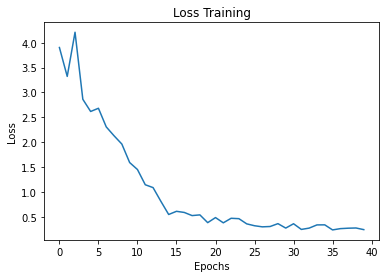

In [ ]:
# Plot the results
np.save('loss_train',loss_)
loss = np.array(loss_)/ 64
fig = plt.figure()
plt.plot(loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Training")
plt.savefig("Loss_Training.png")
plt.show()
np.save('loss_train',loss_)

5. Show a plot of the mean Average Precision over training for your model. (10%)

In [ ]:
...

6. For one image in the inference step, show the predicted bounding boxes in the image before performing any elimination. Then, show the annotated image after the low probability bounding boxes are removed. Finally, show image after performing non-max suppression. Label each of these visualizations. See Figure 4 as an example of what this visualization should look like. (15%)

In [ ]:
...

7. For one image in the inference step, show the bounding boxes visualized for each class with green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights as done in Figure 1. Show the precision/recall curves for each class in inference. Write down the achieved mean Average Precision for your inference stage. (17%)

In [ ]:
...

8. Explain any issues or challenges you had with your implementation. Explain the performance you achieved and any interesting observations you made while training your network. Discuss hypotheses for how you could improve the performance of your implementation further. (20%)

## Some Useful Online Materials

Original YOLO paper:  
https://arxiv.org/pdf/1506.02640.pdf

Intuitive Explanation:  
https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

YOLO Video Tutorial:  
https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30

mean Average Precision:  
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

Intersection over Union:  
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection

## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output. 

For part (a), your submission should consist of this file and a pdf report. This report can simply be a pdf version of this document. Example conversion code below.

**Please save before exporting!**

In [74]:
!sudo apt-get update &> /dev/null
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended &> /dev/null
!jupyter nbconvert  pdf cis680_hw2_final.ipynb

[NbConvertApp] WARNING | pattern u'pdf' matched no files
[NbConvertApp] WARNING | pattern u'cis680_hw2_final.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting n

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()